# Customer behaviour in the electric market and response to dynamic tariffs

## Marcos Escudero Olano

Predicting power demand is of capital importance, especially in grids with a high share of renewables and complex relationships (where some consumers are also producers occasionally). Such power systems are already in place in many European countries and constitute an increasing trend in the coming years. The introduction of smart metering systems in EU countries, among others, is generating a vast amount of data (in the order of Petabytes by now) to utilities: traditionally consumption data per customer was available in monthly intervals, but smart meters provide data every 15 minutes to 1 hour, depending on the system. By 2020 it is expected that at least 80% of EU consumers will have smart metering systems [3].

Nanpeng Yu et al. [1] have identified some important benefits of big data applications in power distribution systems: 
    -Detect energy theft.
    -Detect EV and Rooftop Solar integration.
    -Develop more accurate and granular load forecast.
    -Develop more accurate and granular Renewable generation forecast.
    -Grid state estimation.
    -Equiment diagnosis (e.g.: transformer failure).
    -Model customer consumption behaviour under various incentive and pricing structures. This will be the main focus of this work.
    -Transformation of distribution system planning process.

High demand variability may cause grid unstability. Furthermore, demand peaks might require that more expensive and/or electricity generation power plants take part in energy supply. Utilities (and grid operators) may thus obtain an important benefit by deferring consumption of some consumers. This can be done by various demand response programmes, including Dynamic Time of Use, which will be studied in this work.

The data used in this work is publicly available and derives from a research work carried out in 5567 London households between November 2011 and February 2014: Data and documentation can be downloaded from https://datahub.io/dataset/smartmeter-energy-use-data-in-london-households.

Within the data set are two groups of customers. The first is a sub-group, of approximately 1100 customers, who were subjected to Dynamic Time of Use (dToU) energy prices throughout the 2013 calendar year period.  The tariff prices were given a day ahead via the Smart Meter IHD (In Home Display) or text message to mobile phone. Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied. The dates/times and the price signal schedule is availaible as part of this dataset. All non-Time of Use customers were on a flat rate tariff of 14.228pence/kWh.The signals given were designed to be representative of the types of signal that may be used in the future to manage both high renewable generation (supply following) operation and also test the potential to use high price signals to reduce stress on local distribution grids during periods of stress [7].

References:

[1] N. Yu, S. Shah, R. Johnson, R. Sherick, M. Hong, K. Loparo. "Big Data Analytics in Power Distribution Systems".

[2] A. Albert, R. Rajagopal. "Smart Meter Driven Segmentation: What your consumption says about you". IEEE Transactions on Power Systems (2013).

[3] C. Flath, D. Nicolay, T. Conte, C. van Dinther, L. Filipova-Neumann. "Cluster Analysis of Smart Metering Data". BISE Research Paper (2011).

[4] T. Zufferey, A. Ulbig, S. Koch, G. Hug. "Forecasting of Smart Meter Time Series Based on Neural Networks".

[5] P. Dagnely, T. Ruette, T. Tourwé, E. Tsiporkova, C. Verhelst. "Predicting Hourly Energy Consumption. Can Regression Modeling Improve on an Autoregressive Baseline?"

[6] W. Shen, V. Babushkin, Z. Aung, and W. L. Woon. "An Ensemble Model for Day-ahead Electricity Demand Time Series Forecasting".

[7] https://datahub.io/dataset/smartmeter-energy-use-data-in-london-households

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
pd.options.display.max_columns = None

The complete dataset contains 167 million rows. We will start by reading the sample provided, which corresponds to the whole time series for one user, to see how it looks like.

In [208]:
df_sample = pd.read_csv('https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/UKPN-LCL-smartmeter-sample.csv')

In [209]:
df_sample = df_sample.rename(columns={'KWH/hh (per half hour) ':'kWh/30min'})

In [210]:
df_sample['kWh/30min'] = pd.to_numeric(df_sample['kWh/30min'],'coerce')

In [23]:
type(df_sample['kWh/30min'][3])

numpy.float64

In [55]:
df_sample.shape

(17458, 6)

In [211]:
df_sample['DateTime'] = pd.to_datetime(df_sample['DateTime'])

In [57]:
type(df_sample['DateTime'][2])

pandas.tslib.Timestamp

In [212]:
df_sample.sample(5)

,LCLid,stdorToU,DateTime,kWh/30min,Acorn,Acorn_grouped
7968,MAC003718,Std,2013-01-04 10:30:00,0.387,ACORN-A,Affluent
17233,MAC003718,Std,2013-11-10 08:00:00,0.418,ACORN-A,Affluent
3035,MAC003718,Std,2012-12-19 17:30:00,0.596,ACORN-A,Affluent
15350,MAC003718,Std,2013-02-09 03:00:00,0.123,ACORN-A,Affluent
12517,MAC003718,Std,2013-05-07 03:30:00,0.128,ACORN-A,Affluent


The dataset contains six columns. Its meaning is explained below:

LCLid: Customer ID (5567 different IDs)

stdorToU: Standard (Std) or Dynamic Time of Use (dToU) energy prices

-Standard: flat rate tariff of 14.228p/kWh

-dToU: Customers were issued High (67.20p/kWh), Low (3.99p/kWh) or normal (11.76p/kWh) price signals and the times of day these applied.

ACORN geodemographic segmentation (http://acorn.caci.co.uk/downloads/Acorn-Technical-document.pdf)

Geodemographic, household occupation and lifestyle data are often used when available in smart metering customer segmentation, and usually obtained by surveys, as in [2]. We can use the ACORN geodemographic segmentation in a similar way.

In [213]:
df_sample.isnull().sum()

LCLid            0
stdorToU         0
DateTime         0
kWh/30min        1
Acorn            0
Acorn_grouped    0
dtype: int64

In our sample there is only a missing value. This seems a mistake as the DateTime value does not correspond to a 30-minute interval. Anyway, we should define a systematic way of treating missing values in our dataset. Following a common and simple approach [3] adapted to our dataset, we will treat DateTime and consumption missing values in the following way:

1- Remove data that do not correspond to 30-minute intervals.

2- If missing values extend for more than 1 hour (2 periods), they will be removed.

3- If missing values extend for less than 1 hour, they will be estimated by linear interpolation.

If NAs are present in stdorToU, Acorn or Acorn_grouped, they can be extracted from another row representing the same User ID (LCLid).

If LCLid contains missing values, they will be inferred assuming the data is grouped by LCLid.


In [199]:
def treat_nas(df):
    df_na = df[df['kWh/30min'].isnull()]
    minutes = df_na['DateTime'].apply(lambda x: x.minute)
    to_drop = minutes[(minutes != 0) & (minutes != 30)]
    df = df.drop(to_drop.index[0])
    tmp = df.set_index('DateTime')['kWh/30min'].interpolate(method = 'time', limit = 2, limit_direction = 'both').values
    df['kWh/30min'] = tmp
    df = df.dropna(subset=['kWh/30min'])
    return(df)

Dynamic Time of Use tariffs are contained in https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/Tariffs.xlsx

In [49]:
tariffs = pd.read_excel('https://files.datapress.com/london/dataset/smartmeter-energy-use-data-in-london-households/Tariffs.xlsx', sheetname='Sheet1')

In [365]:
tariffs.sample(5)

,TariffDateTime,Tariff
14618,2013-11-01 13:00:00,Normal
11959,2013-09-07 03:30:00,Normal
1362,2013-01-29 09:00:00,High
11096,2013-08-20 04:00:00,Normal
3120,2013-03-07 00:00:00,Normal


In [50]:
tariffs['TariffDateTime'] = pd.to_datetime(tariffs['TariffDateTime'])

In [367]:
tariffs['Tariff'].value_counts(dropna = False)

Normal    15072
Low        1660
High        788
Name: Tariff, dtype: int64

In [387]:
print("Dynamic Time of Use tarrifs were applied from {start} to {end}. During this time there were {p} 30-min periods.".format(
                start = min(tariffs['TariffDateTime']), 
                end = max(tariffs['TariffDateTime']), 
                p = round((max(tariffs['TariffDateTime']) - min(tariffs['TariffDateTime'])).total_seconds()/60/30+1)))
print("There are {ln} lines.".format(ln = len(tariffs)))
p = round((max(tariffs['TariffDateTime']) - min(tariffs['TariffDateTime'])).total_seconds()/60/30+1)

Dynamic Time of Use tarrifs were applied from 2013-01-01 00:00:00 to 2013-12-31 23:30:00. During this time there were 17520 30-min periods.
There are 17520 lines.


In [389]:
tariffs['TariffDateTime'].apply(lambda x: x.minute).value_counts(dropna = False)

30    8760
0     8760
Name: TariffDateTime, dtype: int64

In [391]:
tariffs['TariffDateTime'].apply(lambda x: x.second).value_counts(dropna = False)

0    17520
Name: TariffDateTime, dtype: int64

In [392]:
tariffs['TariffDateTime'].apply(lambda x: x.hour).value_counts(dropna = False)

15    730
14    730
16    730
1     730
17    730
2     730
18    730
3     730
19    730
4     730
20    730
5     730
21    730
6     730
22    730
7     730
23    730
8     730
9     730
10    730
11    730
12    730
13    730
0     730
Name: TariffDateTime, dtype: int64

In [393]:
tariffs['TariffDateTime'].apply(lambda x: x.day).value_counts(dropna = False)

8     576
23    576
1     576
17    576
2     576
18    576
3     576
19    576
4     576
20    576
5     576
21    576
6     576
22    576
7     576
16    576
15    576
24    576
9     576
25    576
10    576
26    576
11    576
27    576
12    576
28    576
13    576
14    576
29    528
30    528
31    336
Name: TariffDateTime, dtype: int64

In [394]:
tariffs['TariffDateTime'].apply(lambda x: x.month).value_counts(dropna = False)

12    1488
10    1488
8     1488
7     1488
5     1488
3     1488
1     1488
11    1440
9     1440
6     1440
4     1440
2     1344
Name: TariffDateTime, dtype: int64

There are no missing values and datetime values make perfect sense. No need to work further to use Tariff data.

Weather has a noticeable impact on electricity consumption. In many works [2] this is modelled as an effect independent on customer behavioural profiles. It is clear then that we need London weather data with a suitable resolution. We can download such data from darksky.net API in 1-hour intervals.


In [220]:
import json
import requests

This API allows 1000 requests per day. As each request contains data for 24 h, I need one request for each day in the dataset (01/11/2011 - 28/02/2014) - approximately 820. I requested a key for the API and checked the latitude and longitude of Charing Cross, London (51.5073, -0.1276).

In [222]:
def get_weather(start_date,end_date,key='6dd734f200fdb13485eb69bec91e91fc',lat=51.5073,lon=-0.1276):
    weather = pd.DataFrame()
    dates = pd.date_range(start=start_date,end=end_date,freq='D')
    for date in dates: 
        time=date.strftime('%Y-%m-%dT%H:%M:%S')
        url='https://api.darksky.net/forecast/%s/%s,%s,%s?units=si&exclude=currently,flags,daily' %(key,lat,lon,time)
        r = requests.get(url)
        js = json.loads(r.content)
        w = pd.DataFrame(js['hourly']['data'])
        w['time'] = pd.to_datetime(w['time'],unit="s")
        weather = weather.append(w)
    return(weather)

In [223]:
weather = get_weather('2011-11-01','2014-03-01')

In [355]:
weather['time'] = pd.to_datetime(weather['time'])

In [357]:
weather = weather.set_index('time')

In [333]:
weather.tail()

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
20441,5.98,0.28,-0.17,0.65,partly-cloudy-night,rain,1001.92,Partly Cloudy,5.98,2014-03-01 19:00:00,12.60,210,1.17
20442,5.19,NaN,-0.11,0.63,clear-night,rain,1002.34,Clear,6.33,2014-03-01 20:00:00,12.78,232,1.73
20443,3.48,0.00,-0.17,0.69,clear-night,rain,1002.65,Clear,5.00,2014-03-01 21:00:00,13.36,228,1.89
20444,2.05,0.00,-0.25,0.73,clear-night,rain,1002.40,Clear,4.06,2014-03-01 22:00:00,13.58,220,2.22
20445,2.70,0.00,0.62,0.77,clear-night,rain,1001.94,Clear,4.36,2014-03-01 23:00:00,13.71,209,1.92


In [265]:
len(weather)

20446

In [334]:
weather.isnull().sum()

apparentTemperature      0
cloudCover             865
dewPoint                 0
humidity                 0
icon                     0
precipType               0
pressure                11
summary                  0
temperature              0
time                     0
visibility               0
windBearing              0
windSpeed                0
dtype: int64

In [335]:
print(weather['summary'].value_counts())
print("There are {n} levels in variable 'summary'".format(n=len(weather['summary'].value_counts())))

Partly Cloudy               6892
Mostly Cloudy               6453
Clear                       4977
Overcast                    1109
Foggy                        695
Breezy and Mostly Cloudy      95
Breezy and Partly Cloudy      82
Breezy                        46
Windy and Mostly Cloudy       31
Breezy and Overcast           22
Windy                         18
Windy and Overcast             9
Dry                            9
Dry and Mostly Cloudy          5
Windy and Partly Cloudy        2
Dry and Partly Cloudy          1
Name: summary, dtype: int64
There are 16 levels in variable 'summary'


In [336]:
print(weather['icon'].value_counts())
print("There are {n} levels in variable 'icon'".format(n=len(weather['icon'].value_counts())))

partly-cloudy-day      7840
partly-cloudy-night    5511
clear-night            4082
cloudy                 1109
clear-day               904
fog                     695
wind                    305
Name: icon, dtype: int64
There are 7 levels in variable 'icon'


In [337]:
weather['precipType'].value_counts()

rain    20029
snow      417
Name: precipType, dtype: int64

Before continuning we can save the weather data as a csv so we do not need to download them again.

In [309]:
weather.to_csv('data/weather.csv')

Unfortunately the precipitation amount (as used in [2]) is not included in this weather data. In any case, Albert and Rajagopal [2] concluded that precipitation amount was the less explicative of the weather variables they used.

Variable "precipType" only tells us whether possible precipitation is rain or snow, but not whether there was actually precipitation. Therefore, we will discard it, assuming that other variables can cover this information (namely humidity, cloud cover and pressure). We prefer to use these 3 variables rather than the 16-level categorical variable "summary". 

Therefore, we will use the following variables:

-Temperature

-Humidity

-Cloud cover

-Pressure

Only cloud cover and pressure contain missing values. Let us examine a reasonable way of dealing with them.

We will start by examining the relationship between Cloud Cover and summary. Except for foggy weather, summary seems to give us a reasonable idea of the value of Cloud Cover. Therefore, it is proposed to impute the median value of Cloud Cover for "summary" in each NA.

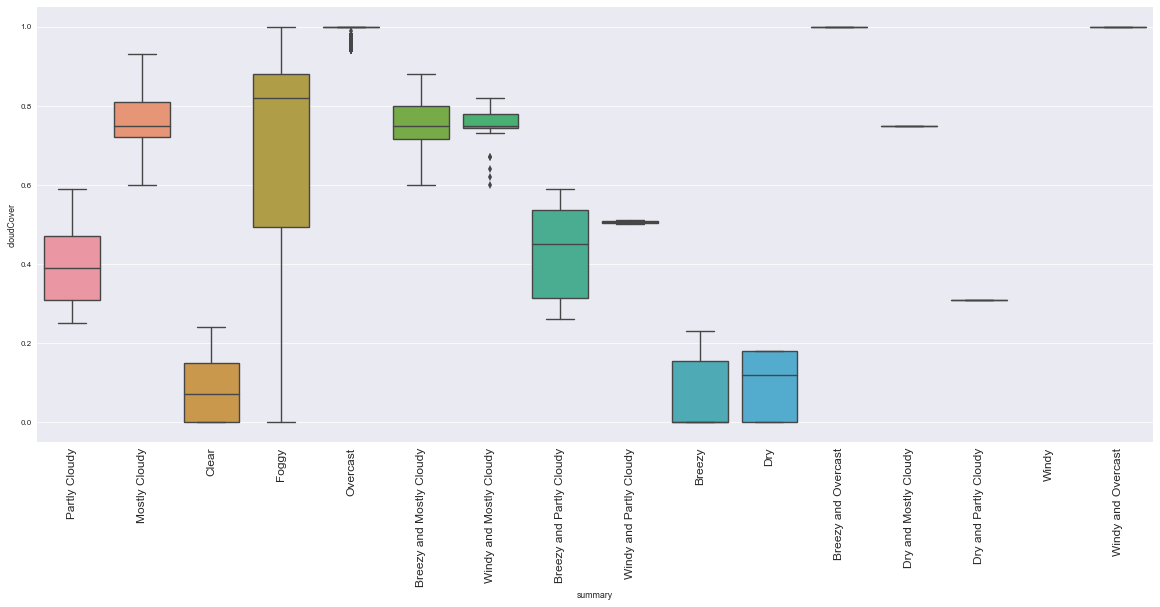

In [291]:
plt.figure(figsize=(20, 8))
g1 = sns.boxplot(weather['summary'], weather['cloudCover'])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90, fontsize = 12)
plt.show()

Now we will examine the Pressure values. As there are only 11 values, we can look at all of them directly. It can be noticed that there is no series of more than one missing value (the maximum gap is 1 hour).

In [266]:
weather[weather['pressure'].isnull()]

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
4530,12.97,0.34,8.28,0.73,partly-cloudy-day,rain,NaN,Partly Cloudy,12.97,2012-05-07 18:00:00,11.27,189,4.25
8655,4.19,0.78,3.60,0.77,partly-cloudy-day,rain,NaN,Mostly Cloudy,7.31,2012-10-26 15:00:00,11.27,21,5.08
10303,7.09,0.77,8.67,0.94,partly-cloudy-night,rain,NaN,Mostly Cloudy,9.64,2013-01-03 07:00:00,9.62,250,5.15
14077,13.47,NaN,7.74,0.68,clear-day,rain,NaN,Clear,13.47,2013-06-09 13:00:00,9.98,47,5.11
15336,19.07,NaN,16.73,0.86,clear-night,rain,NaN,Clear,19.07,2013-08-01 00:00:00,9.98,189,2.82
15697,16.98,0.00,14.84,0.87,clear-night,rain,NaN,Clear,16.98,2013-08-16 01:00:00,9.98,217,3.84
15935,17.58,0.00,15.51,0.88,clear-night,rain,NaN,Clear,17.58,2013-08-25 23:00:00,6.32,10,3.75
15936,17.04,0.00,15.44,0.90,clear-night,rain,NaN,Clear,17.04,2013-08-26 00:00:00,4.39,358,2.74
16273,7.98,0.00,8.00,0.91,clear-night,rain,NaN,Clear,9.33,2013-09-09 01:00:00,9.50,219,2.57
16276,9.56,0.00,7.72,0.86,clear-night,rain,NaN,Clear,9.92,2013-09-09 04:00:00,9.45,224,1.50


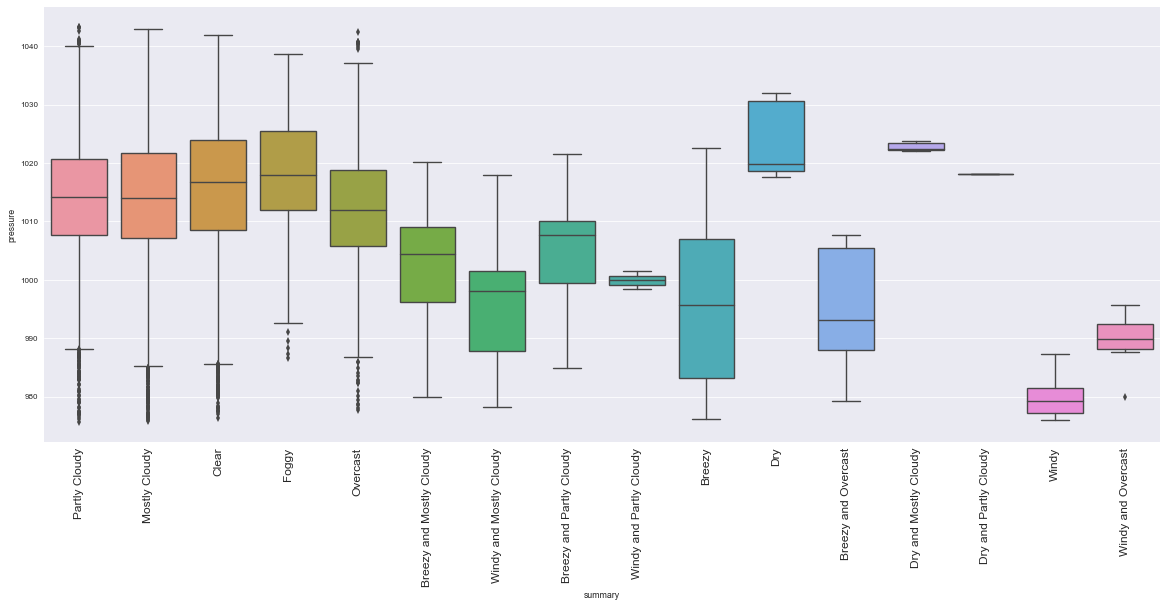

In [297]:
plt.figure(figsize=(20, 8))
g2 = sns.boxplot(weather['summary'], weather['pressure'])
g2.set_xticklabels(g2.get_xticklabels(),rotation=90, fontsize = 12)
plt.show()

In [298]:
weather.ix[15330:15340] # Examine a sample in which there is Pressure NaN

,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipType,pressure,summary,temperature,time,visibility,windBearing,windSpeed
15330,21.34,0.81,16.21,0.73,partly-cloudy-day,rain,1014.75,Mostly Cloudy,21.34,2013-07-31 18:00:00,12.33,215,5.34
15331,20.81,0.81,16.11,0.75,partly-cloudy-day,rain,1014.83,Mostly Cloudy,20.81,2013-07-31 19:00:00,12.33,216,4.94
15332,20.34,1.00,16.18,0.77,cloudy,rain,1014.89,Overcast,20.34,2013-07-31 20:00:00,12.89,218,4.69
15333,20.22,1.00,16.22,0.78,cloudy,rain,1015.04,Overcast,20.22,2013-07-31 21:00:00,12.89,219,3.81
15334,20.14,1.00,16.49,0.80,cloudy,rain,1014.84,Overcast,20.14,2013-07-31 22:00:00,12.89,212,3.06
15335,19.66,1.00,16.55,0.82,cloudy,rain,1014.47,Overcast,19.66,2013-07-31 23:00:00,12.89,198,2.48
15336,19.07,NaN,16.73,0.86,clear-night,rain,NaN,Clear,19.07,2013-08-01 00:00:00,9.98,189,2.82
15337,18.95,0.75,16.54,0.86,partly-cloudy-night,rain,1013.78,Mostly Cloudy,18.95,2013-08-01 01:00:00,12.68,183,2.65
15338,18.78,0.75,16.48,0.87,partly-cloudy-night,rain,1013.43,Mostly Cloudy,18.78,2013-08-01 02:00:00,10.83,178,2.66
15339,17.82,0.12,16.03,0.89,clear-night,rain,1012.96,Clear,17.82,2013-08-01 03:00:00,10.12,160,1.50


Atmospheric pressure variability is smaller than that of other variables (including Cloud Cover). Furthermore, it does not seem it can be inferred from the value of "summary". It is therefore proposed to fill the 11 missing values by linear interpolation.

In [346]:
median_cloud = weather.groupby('summary').median()['cloudCover']
median_cloud

summary
Breezy                      0.000
Breezy and Mostly Cloudy    0.750
Breezy and Overcast         1.000
Breezy and Partly Cloudy    0.450
Clear                       0.070
Dry                         0.120
Dry and Mostly Cloudy       0.750
Dry and Partly Cloudy       0.310
Foggy                       0.820
Mostly Cloudy               0.750
Overcast                    1.000
Partly Cloudy               0.390
Windy                         NaN
Windy and Mostly Cloudy     0.750
Windy and Overcast          1.000
Windy and Partly Cloudy     0.505
Name: cloudCover, dtype: float64

In [305]:
weather[weather['cloudCover'].isnull()]['summary'].value_counts()

Clear     780
Breezy     34
Foggy      33
Windy      18
Name: summary, dtype: int64

All "Windy" Cloud Cover values (18) are NaN. However, comparing the other summary caterogies cointaining "windy" with their "breezy" counterparts, we can assume the same median as "Breezy".

In [351]:
weather.loc[(weather['cloudCover'].isnull()) & (weather['summary'] == 'Clear'),'cloudCover'] = median_cloud['Clear']
weather.loc[(weather['cloudCover'].isnull()) & (weather['summary'] == 'Breezy'),'cloudCover'] = median_cloud['Breezy']
weather.loc[(weather['cloudCover'].isnull()) & (weather['summary'] == 'Foggy'),'cloudCover'] = median_cloud['Foggy']
weather.loc[(weather['cloudCover'].isnull()) & (weather['summary'] == 'Windy'),'cloudCover'] = median_cloud['Breezy']

In [360]:
weather['pressure'] = weather['pressure'].interpolate(method = 'time', limit_direction = 'both').values

In [361]:
weather.isnull().sum()

apparentTemperature    0
cloudCover             0
dewPoint               0
humidity               0
icon                   0
precipType             0
pressure               0
summary                0
temperature            0
visibility             0
windBearing            0
windSpeed              0
dtype: int64

In [362]:
weather.to_csv('data/weather_no_na.csv')

Electricity consumption is different in working days and holidays. Therefore, we need to know the bank holidays applicable in London between November 2011 and February 2014. We can use the python "holidays" package for this purpose.

School holidays also have a potential impact on electricity consumption, but we have not found a reliable source for school holidays in London in the period 2011-2014 so we will not use it in our prediction models.

In [ ]:
#!pip install holidays 
#to be executed only if we do not have this package installed

In [1]:
import holidays

In [11]:
for date, name in sorted(holidays.England(years=range(2011,2015)).items()):
    print(date, name)

2011-01-01 New Year's Day
2011-01-03 New Year's Day (Observed)
2011-04-22 Good Friday
2011-04-25 Easter Monday
2011-04-29 Wedding of William and Catherine
2011-05-02 May Day
2011-05-30 Spring Bank Holiday
2011-08-29 Late Summer Bank Holiday
2011-12-25 Christmas Day
2011-12-26 Boxing Day
2011-12-27 Christmas Day (Observed)
2012-01-01 New Year's Day
2012-01-02 New Year's Day (Observed)
2012-04-06 Good Friday
2012-04-09 Easter Monday
2012-05-07 May Day
2012-06-04 Spring Bank Holiday
2012-06-05 Diamond Jubilee of Elizabeth II
2012-08-27 Late Summer Bank Holiday
2012-12-25 Christmas Day
2012-12-26 Boxing Day
2013-01-01 New Year's Day
2013-03-29 Good Friday
2013-04-01 Easter Monday
2013-05-06 May Day
2013-05-27 Spring Bank Holiday
2013-08-26 Late Summer Bank Holiday
2013-12-25 Christmas Day
2013-12-26 Boxing Day
2014-01-01 New Year's Day
2014-04-18 Good Friday
2014-04-21 Easter Monday
2014-05-05 May Day
2014-05-26 Spring Bank Holiday
2014-08-25 Late Summer Bank Holiday
2014-12-25 Christmas D

This is consistent with the bank holidays listed in https://www.gov.uk/bank-holidays

In [12]:
#I only need to know the dates, not the holiday names
bank_hol = []
for date, name in sorted(holidays.England(years=range(2011,2015)).items()):
    bank_hol.append(date)

In [13]:
pd.Series(bank_hol).to_csv('data/bank_holidays.csv')